# IEEE eScience paper

Compare stances over time derived from tweets with stances from other sources, for example RIVM behavioral studies.

This notebook reuses code from the notebooks:
* domain-adaptation.ipynb
* fasttext.ipynb
* tweet-counts.ipynb

RIVM measures that were evaluated:
* Naleving gedragsregels / Houden aan gedragsregels / Voldoende afstand houden van anderen
* Naleving gedragsregels / Houden aan gedragsregels / Mondkapje in publieke binnenruimten
* Naleving gedragsregels / Testen / Klachten totaal
* Vaccinatiebereidheid / Totaal
* (Naleving gedragsregels / Avondklok)

## 1. Read data

In [42]:
from nltk.tokenize import TweetTokenizer
import pandas as pd

In [2]:
DATA_DIR = "../data/"
ANNOTATION_DIR = DATA_DIR + "annotation/"
DISTANCE = "distance"
FACEMASK = "mondkapje"
TESTING = "testing"
VACCINATION = "vaccin"
IDSTR = "id_str"
IRRELEVANT = "ANDERS"
TOTAL = "total"

In [3]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

In [4]:
def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

In [5]:
def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [6]:
def select_annotations(annotations_in, tweets, main_annotator):
    annotations_out = {}
    for i, row in annotations_in.iterrows():
        if row[0]== main_annotator:
            id_str = row[2]
            label = row[4]
            if id_str in tweets.index:
                annotations_out[id_str] = { "label": label, "text": preprocess(tweets.loc[id_str]["text"]) }
    return annotations_out

In [7]:
def read_data_topic(topic):
    if topic == TESTING:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202012.csv"
    elif topic == FACEMASK:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202103-1000.csv"
    elif topic == VACCINATION:
        tweet_file = ANNOTATION_DIR + topic + "-202001-202101-1000.csv"
    elif topic == DISTANCE:
        tweet_file = DATA_DIR + topic + "-tweets.csv"
    else:
        print(f"read_fasttext_data: unknown topic: {topic}")
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")
    main_annotator = annotations.iloc[0][0]
    annotations = select_annotations(annotations, tweets, main_annotator)
    return annotations, main_annotator

In [8]:
def store_annotations(annotations, topic):
    pd.DataFrame([[key, annotations[key]["label"]] for key in annotations], columns=["id_str", "label"]).to_csv(f"data-{topic}.csv", 
                                                                                                                index=False)

In [9]:
def read_all_data(topics):
    annotations = {}
    for topic in topics:
        annotations[topic], main_annotator = read_data_topic(topic)
        print(f"read topic {topic}: {len(annotations[topic])} annotations from {main_annotator}")
    return annotations

In [10]:
annotations = read_all_data([DISTANCE, FACEMASK, TESTING, VACCINATION])

read topic distance: 5977 annotations from erikt@xs4all.nl
read topic mondkapje: 1011 annotations from erikt@xs4all.nl
read topic testing: 1181 annotations from erikt@xs4all.nl
read topic vaccin: 1007 annotations from erikt@xs4all.nl


## 2. Run fastText

In [16]:
import fasttext
import os
import re
import tempfile

In [28]:
TEXT = "text"
TEXT_DIR = DATA_DIR + "text/"
DISTANCE_QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
FACEMASK_QUERY = "mondkapje"
TEST_QUERY = r'\btest|getest|sneltest|pcr'
VACCIN_QUERY = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech"
RIVM_ROUNDS = [ "^2020041[7-9]|^2020042[0-4]", "^2020050[7-9]|^2020051[0-2]", "^2020052[7-9]|^2020053|^20200601", "^2020061[7-9]|^2020062[0-1]",
                "^2020070[8-9]|^2020071[0-2]", "^20200819|^2020082[0-3]",     "^20200930|^2020100[1-4]",          "^2020111[1-5]",
                "^2020123|^2021010[1-3]",      "^2021021[0-4]",               "^2021032[4-8]",                    "^2021050[5-9]" ]

In [29]:
def read_data_fasttext(date_pattern, query, data_directory=TEXT_DIR):
    file_list = sorted(os.listdir(data_directory))
    test_data = []
    hours = 0
    for in_file_name in file_list:
        if re.search(date_pattern, in_file_name) and os.path.exists(data_directory + in_file_name):
            try:
                file_data = pd.read_csv(data_directory + in_file_name).drop_duplicates()
                matched_text = file_data[file_data[TEXT].str.contains(query, case=False)]
                matched_text_preprocessed = matched_text[TEXT].apply(lambda x: preprocess(x))
                test_data.extend(list(matched_text_preprocessed))
                hours += 1
            except:
                pass
    return test_data, hours

In [30]:
def classify(date_pattern, query, model, data_directory=TEXT_DIR):
    test_data, hours = read_data_fasttext(date_pattern, query, data_directory)
    predicted_labels = model.predict(test_data)
    predicted_groups = pd.DataFrame(predicted_labels[0]).groupby(0).groups
    label_counts_predicted = { label: len(predicted_groups[label]) for label in predicted_groups}
    nbr_of_labels = sum([ label_counts_predicted[label] for label in label_counts_predicted if label != IRRELEVANT ])
    label_percentages = { label: round(100*label_counts_predicted[label] / nbr_of_labels, 1) for label in label_counts_predicted }
    label_percentages[TOTAL] = nbr_of_labels
    label_percentages["hours"] = hours
    return label_percentages

In [31]:
def make_fasttext_model(annotations):
    _, path = tempfile.mkstemp()
    data_file = open(path, "w")
    for id_str in annotations:
        print(f'__label__{annotations[id_str]["label"]} {preprocess(annotations[id_str]["text"])}', 
              file=data_file)
    data_file.close()
    model = fasttext.train_supervised(path, dim=300, pretrainedVectors="twiqs-model-2020.vec")
    os.remove(path)
    return model

In [15]:
topic = "testing"
model = make_fasttext_model(annotations[topic])

In [34]:
classifications = {}
classifications[topic] = {}
for date_pattern in RIVM_ROUNDS:
    classifications[topic][date_pattern] = classify(date_pattern, TEST_QUERY, model)

In [35]:
classifications

{'testing': {'^2020041[7-9]|^2020042[0-4]': {'__label__ANDERS': 65.8,
   '__label__EENS': 26.9,
   '__label__ONEENS': 7.2,
   'total': 54013,
   'hours': 192},
  '^2020050[7-9]|^2020051[0-2]': {'__label__ANDERS': 65.0,
   '__label__EENS': 29.2,
   '__label__ONEENS': 5.8,
   'total': 35286,
   'hours': 144},
  '^2020052[7-9]|^2020053|^20200601': {'__label__ANDERS': 69.3,
   '__label__EENS': 24.0,
   '__label__ONEENS': 6.7,
   'total': 24869,
   'hours': 144},
  '^2020061[7-9]|^2020062[0-1]': {'__label__ANDERS': 79.0,
   '__label__EENS': 14.9,
   '__label__ONEENS': 6.1,
   'total': 13506,
   'hours': 120},
  '^2020070[8-9]|^2020071[0-2]': {'__label__ANDERS': 75.6,
   '__label__EENS': 16.5,
   '__label__ONEENS': 7.8,
   'total': 12938,
   'hours': 120},
  '^20200819|^2020082[0-3]': {'__label__ANDERS': 68.9,
   '__label__EENS': 15.3,
   '__label__ONEENS': 15.8,
   'total': 25829,
   'hours': 120},
  '^20200930|^2020100[1-4]': {'__label__ANDERS': 69.0,
   '__label__EENS': 12.8,
   '__label_

In [36]:
## 3. Plot

In [37]:
import matplotlib.pyplot as plt

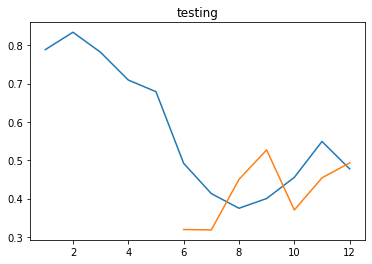

In [41]:
x = range(1, 1+len(classifications[topic]))
y = [ classifications[topic][date_pattern]["__label__EENS"] / (classifications[topic][date_pattern]["__label__EENS"] + 
                                                               classifications[topic][date_pattern]["__label__ONEENS"] ) 
      for date_pattern in classifications[topic]]
x_rivm = [6, 7, 8, 9, 10, 11, 12]
y_rivm = [0.319, 0.318, 0.450, 0.527, 0.370, 0.454, 0.493]
plt.plot(x, y)
plt.plot(x_rivm, y_rivm)
plt.title(topic)
plt.show()

# Old code from domain-adaptation.ipynb

In [ ]:
import datetime
import fasttext
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy.stats
import uuid
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [ ]:
DATADIR = "../data/"
ANNOTATION_DIR = DATADIR + "annotation/"
DISTANCE = "distance"
FACEMASK = "mondkapje"
TESTING = "testing"
VACCINATION = "vaccin"
LONELY = "eenzaam"
FILEFASTTEXT = "fasttext.csv"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
ANDERS = "ANDERS"
EENS = "EENS"
ONEENS = "ONEENS"
SUPPORTS = "SUPPORTS"
REJECTS = "REJECTS"
LABEL = "label"
TEXT = "text"
USER = "user"
LABELPREFIX = "__label__"
LARGEINT = 9999999999

In [ ]:
DIM = 300
EPOCH = 200
LR = 0.2
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))
VALIDATION = "VALIDATION"+str(int(random.random()*LARGEINT))

In [ ]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)


def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))


def preprocess(text):
    return(tokenize(cleanup(text)).lower())


def select_annotations(tweets, annotations, target_annotator):
    fasttext_data = {}
    for i in range(0,len(annotations)):
        annotator = annotations.iloc[i][0]
        tweet_id = annotations.iloc[i][2]
        if annotator == target_annotator and tweet_id in list(tweets.index):
            tweet_user = tweets.loc[tweet_id][1]
            tweet_label = annotations.iloc[i][4]
            if tweet_label == NEUTRAL: tweet_label = IRRELEVANT
            if tweet_label == ANDERS: tweet_label = IRRELEVANT
            if tweet_label == EENS: tweet_label = SUPPORTS
            if tweet_label == ONEENS: tweet_label = REJECTS
            fasttext_data[tweet_id] = { LABEL:LABELPREFIX+tweet_label,
                                        USER:tweet_user,
                                        TEXT:preprocess(tweets.loc[tweet_id][TEXT]) }
    return({tweet_id: fasttext_data[tweet_id] for tweet_id in sorted(fasttext_data.keys())})


def store_fasttext_data_fixed(fasttext_data):
    outfile = open(FILEFASTTEXT, "w")
    seen_texts = {}
    fasttext_data_list = []
    tweet_ids = []
    for tweet_id in fasttext_data:
        text = cleanup(fasttext_data[tweet_id][TEXT])
        if not text in seen_texts:
            print(fasttext_data[tweet_id][LABEL], text, file=outfile)
            fasttext_data_list.append(" ".join([fasttext_data[tweet_id][LABEL], text]))
            tweet_ids.append(tweet_id)
            seen_texts[text] = True
    outfile.close()
    return(fasttext_data_list, tweet_ids)

In [ ]:
def make_fasttext_data(topic):
    if topic == TESTING:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202012.csv"
    elif topic == FACEMASK:
        tweet_file = ANNOTATION_DIR + topic + "-202003-202103-1000.csv"
    elif topic == VACCINATION:
        tweet_file = ANNOTATION_DIR + topic + "-202001-202101-1000.csv"
    elif topic == DISTANCE:
        tweet_file = DATADIR + topic + "-tweets.csv"
    elif topic == LONELY:
        tweet_file = ANNOTATION_DIR + topic + "_2020.csv"
    else:
        print(f"make_fasttext_data: cannot happen! ({topic})")
    tweets = pd.read_csv(tweet_file, index_col=IDSTR)
    annotations = pd.read_csv(tweet_file + ".human-labels.txt", header=None, sep=" ")        
    main_annotator = annotations.iloc[0][0]
    fasttext_data = select_annotations(tweets, annotations, main_annotator)
    fasttext_data_list, tweet_ids = store_fasttext_data_fixed(fasttext_data)
    return(fasttext_data_list, tweet_ids)

In [ ]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True,printMatrix=False):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    try:
        cf = makeConfusionMatrix(fasttextData,predictionLabels)
        if printMatrix:
            print(cf)
        for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
            if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
        numberOfPredictedSupportLabels = sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))])
        numberOfGoldSupportLabels = sum(cf.loc['__label__SUPPORTS'])
        numberOfPredictedRejectLabels = sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])
        numberOfGoldRejectLabels = sum(cf.loc['__label__REJECTS'])
        if numberOfPredictedSupportLabels > 0 and numberOfGoldRejectLabels > 0 and numberOfGoldSupportLabels > 0:
            fraction = (numberOfPredictedRejectLabels/numberOfPredictedSupportLabels)/(numberOfGoldRejectLabels/numberOfGoldSupportLabels)
        else:
            fraction = LARGEINT
    except:
        fraction = 0
    if printResults: 
        print("cases: {0}; precision: {1:0.3f}; recall: {2:0.3f}; fraction: {3:0.3f}".format(caseTotal,precision,recall,fraction))
    return((precision,fraction))

def runFasttext(fasttextData1, fasttextData2, dim=DIM, epoch=EPOCH, lr=LR, n=N, squealFlag=True, maxTrain=None, pretrainedVectors=None):
    print(f"data size 1={len(fasttextData1)}, data size 2={len(fasttextData2)}, dim={dim}, epoch={epoch}, lr={lr}, pretrainedVectors={pretrainedVectors}")
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    precision, fraction = evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation, predictionLabelsValidation, predictionCountsTest, predictionLabelsTest, precision)

In [ ]:
fasttext_data_list_distance, tweet_ids_distance = make_fasttext_data(DISTANCE)
fasttext_data_list_facemask, tweet_ids_facemask = make_fasttext_data(FACEMASK)
fasttext_data_list_testing, tweet_ids_testing = make_fasttext_data(TESTING)
fasttext_data_list_vaccination, tweet_ids_vaccination = make_fasttext_data(VACCINATION)

In [ ]:
fasttext_data_list_lonely, tweet_ids_lonely = make_fasttext_data(LONELY)

In [ ]:
len(tweet_ids_distance), len(tweet_ids_facemask), len(tweet_ids_testing), len(tweet_ids_vaccination), len(tweet_ids_lonely)

In [ ]:
def store_fasttext_data(data, file_name):
    with open(file_name, "wb") as outfile:
        pickle.dump(data, outfile)
        outfile.close()
        
def read_fasttext_data(file_name):
    with open(file_name, "rb") as infile:
        data = pickle.load(infile)
        infile.close()
    return(data)

## 1. Evaluation within domains (TGTONLY)

In [ ]:
def get_prediction_labels_list(prediction_labels_10cv):
    prediction_labels = []
    for i in range(0, len(prediction_labels_10cv)):
        prediction_labels.extend([row[0] for row in prediction_labels_10cv[i][0]])
    return prediction_labels


def compute_accuracy(prediction_labels, fasttext_data_list):
    correct = 0
    for i in range(0, len(fasttext_data_list)):
        gold_label = fasttext_data_list[i].split(" ")[0]
        if prediction_labels[i] == gold_label:
            correct += 1
    return(round(correct / len(fasttext_data_list), 3))

In [ ]:
predictionCountsValidationLLT,predictionLabelsValidationLLT,predictionCountsTestLLT,predictionLabelsTestLLT, precision = \
    runFasttext(fasttext_data_list_lonely, fasttext_data_list_lonely, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestLLT, f"predictionLabelsTestLLT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationDDT,predictionLabelsValidationDDT,predictionCountsTestDDT,predictionLabelsTestDDT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_distance, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestDDT, f"predictionLabelsTestDDT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationFFT,predictionLabelsValidationFFT,predictionCountsTestFFT,predictionLabelsTestFFT = \
    runFasttext(fasttext_data_list_facemask, fasttext_data_list_facemask, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestFFT, f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
accuracies = []
for i in range(0, 10):
    predictionCountsValidationTTT, predictionLabelsValidationTTT, predictionCountsTestTTT, predictionLabelsTestTTT, accuracy = \
        runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")
    accuracies.append(accuracy)
print(accuracies)

In [ ]:
store_fasttext_data(predictionLabelsTestTTT, f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationVVT,predictionLabelsValidationVVT,predictionCountsTestVVT,predictionLabelsTestVVT = \
    runFasttext(fasttext_data_list_vaccination, fasttext_data_list_vaccination, squealFlag=False, pretrainedVectors="twiqs-model-2020-exf.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestVVT, f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
compute_accuracy(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")), fasttext_data_list_testing)

## 2. Evaluation of other domains with social distancing data (SRCONLY)

In [ ]:
model_distance = fasttext.train_supervised("fasttext-distance.csv", dim=DIM, epoch=EPOCH, lr=LR, pretrainedVectors="twiqs-model-2020-exf.vec")

In [ ]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_distance)]), fasttext_data_list_distance)

In [ ]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_facemask)]), fasttext_data_list_facemask)

In [ ]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_testing)]), fasttext_data_list_testing)

In [ ]:
compute_accuracy(get_prediction_labels_list([model_distance.predict(fasttext_data_list_vaccination)]), fasttext_data_list_vaccination)

## Predicting social distancing with facemask data (old)

In [ ]:
def count_labels(fasttext_data_list):
    counts = {}
    for i in range(0, len(fasttext_data_list)):
        token_list = fasttext_data_list[i].split()
        if token_list[0] in counts:
            counts[token_list[0]] += 1
        else:
            counts[token_list[0]] = 1
    return(counts)


def swap_labels(fasttext_data_list_in):
    fasttext_data_list_out = []
    for i in range(0, len(fasttext_data_list_in)):
        token_list = fasttext_data_list_in[i].split()
        if token_list[0] == "__label__REJECTS":
            token_list[0] = "__label__SUPPORTS"
        elif token_list[0] == "__label__SUPPORTS":
            token_list[0] = "__label__REJECTS"
        fasttext_data_list_out.append(" ".join(token_list))
    return(fasttext_data_list_out)

In [ ]:
if False:
    predictionCountsValidationFD,predictionLabelsValidationFD,predictionCountsTestFD,predictionLabelsTestFD = \
        runFasttext(fasttext_data_list_facemask, fasttext_data_list_distance, squealFlag=False, dim=300)

In [ ]:
predictionCountsValidationDFT, predictionLabelsValidationDFT, predictionCountsTestDFT, predictionLabelsTestDFT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestDFT, f"predictionLabelsTestDFT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationDTT, predictionLabelsValidationDTT, predictionCountsTestDTT, predictionLabelsTestDTT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestDTT, f"predictionLabelsTestDTT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationDVT, predictionLabelsValidationDVT, predictionCountsTestDVT, predictionLabelsTestDVT = \
    runFasttext(fasttext_data_list_distance, fasttext_data_list_vaccination, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestDVT, f"predictionLabelsTestDVT-{DIM}-{EPOCH}-{LR}.pickle")

### Old code

In [ ]:
predictionLabelsTestFD = read_fasttext_data("predictionLabelsTestFD.pickle")
predictionLabelsTestDD = read_fasttext_data("predictionLabelsTestDD.pickle")

In [ ]:
def convert(data):
    plot_data =[]
    for key in data:
        if re.search("^[0-9]+$", str(key)):
            support_count = 0
            reject_count = 0
            for label in data[key]:
                if label == "__label__SUPPORTS":
                    support_count += 1
                if label == "__label__REJECTS":
                    reject_count += 1
            if support_count+reject_count > 0:
                plot_data.append((int(key), support_count/(support_count+reject_count)))
    plot_data = [x for x in sorted(plot_data, key=lambda x:x[0])]
    return(plot_data)

In [ ]:
def make_data_predicted(predictionLabelsTest, tweet_ids, time_factor=4):
    predicted = []
    for i in range(0, len(predictionLabelsTest)):
        for j in range(0, len(predictionLabelsTest[i][0])):
            predicted.append(predictionLabelsTest[i][0][j])
    data_predicted = {}
    for i in range(0, len(tweet_ids)):
        summary = str(tweet_ids[i])[0:time_factor]
        if summary not in data_predicted:
            data_predicted[summary] = []
        data_predicted[summary].append(predicted[i][0])
    return(data_predicted)

In [ ]:
time_factor = 4
data_predicted_fd = make_data_predicted(predictionLabelsTestFD, tweet_ids_distance, time_factor=time_factor)
data_predicted_dd = make_data_predicted(predictionLabelsTestDD, tweet_ids_distance, time_factor=time_factor)

In [ ]:
gold = []
for tweet in fasttext_data_list_distance:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_distance)):
    summary = str(tweet_ids_distance[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

In [ ]:
plot_data_predicted_fd = convert(data_predicted_fd)
plot_data_predicted_dd = convert(data_predicted_dd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Inflate predictions (old)

In [ ]:
def get_freqs(label_list):
    freqs = {}
    for label in label_list:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    for label in freqs:
        freqs[label] /= len(label_list)
    return(freqs)

In [ ]:
def inflate(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]*factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [ ]:
def inflate_plus(predictionLabelsTestIn, source_label, target_label, factor):
    predictionLabelsTestOut = list(predictionLabelsTestIn)
    counter = 0
    for fold in predictionLabelsTestOut:
        for i in range(0, len(fold[0])):
            if fold[0][i][0] == target_label:
                for j in range(0, len(fold[0][i])):
                    if fold[0][i][j] == source_label:
                        break
                if fold[0][i][j] != source_label:
                    sys.exit("cannot happen")
                if fold[1][i][j]+factor > fold[1][i][0]:
                    fold[0][i][0], fold[0][i][j] = fold[0][i][j], fold[0][i][0]
    return(predictionLabelsTestOut)

In [ ]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
FACTOR = 0.9967

predictionLabelsTestFDinflated = list(predictionLabelsTestFD)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestFDinflated, '__label__SUPPORTS', '__label__REJECTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
data_predicted_fd_inflated = make_data_predicted(predictionLabelsTestFDinflated, tweet_ids_distance)
plot_data_predicted_fd_inflated = convert(data_predicted_fd_inflated)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_fd = [x[0] for x in plot_data_predicted_fd]
y_fd = [x[1] for x in plot_data_predicted_fd]
x_dd = [x[0] for x in plot_data_predicted_dd]
y_dd = [x[1] for x in plot_data_predicted_dd]
x_fd_inflated = [x[0] for x in plot_data_predicted_fd_inflated]
y_fd_inflated = [x[1] for x in plot_data_predicted_fd_inflated]
plt.plot(x_fd, y_fd, label="predicted (out-of-domain)")
plt.plot(x_dd, y_dd, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_fd_inflated, y_fd_inflated, label="predicted (out-of-domain, inflated")
plt.legend()
plt.title("predicting social distancing with facemask data")
plt.savefig("facemask-to-distancing.png")
plt.show()

### Numerical analysis of predictions (old)

In [ ]:
plot_data_predicted_fd_dict = { x[0]:x[1] for x in plot_data_predicted_fd }
plot_data_predicted_dd_dict = { x[0]:x[1] for x in plot_data_predicted_dd }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }
plot_data_predicted_fd_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_fd_inflated }

In [ ]:
def get_common_key_values(dict1, dict2):
    values1 = []
    values2 = []
    for key in sorted(dict1.keys()):
        if key in dict2:
            values1.append(dict1[key])
            values2.append(dict2[key])
    return(values1, values2)

In [ ]:
values_dd, values_gold_dd = get_common_key_values(plot_data_predicted_dd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_dd), np.array(values_dd)).rvalue, 2))
values_fd, values_gold_fd = get_common_key_values(plot_data_predicted_fd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd)).rvalue, 2))
values_fd_inflated, values_gold_fd_inflated = get_common_key_values(plot_data_predicted_fd_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_fd), np.array(values_fd_inflated)).rvalue, 2))

In [ ]:
def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(absolute_difference/len(list1))

In [ ]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_dd, values_dd), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_fd, values_fd),2))
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_fd_inflated, values_fd_inflated),2)) 

## Predicting facemasks with social distancing data (old)

In [ ]:
if False:
    predictionCountsValidationDF,predictionLabelsValidationDF,predictionCountsTestDF,predictionLabelsTestDF = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300)

In [ ]:
if False:
    predictionCountsValidationDFT,predictionLabelsValidationDFT,predictionCountsTestDFT,predictionLabelsTestDFT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_facemask, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
if False:
    store_fasttext_data(predictionLabelsTestDFT, "predictionLabelsTestDFT.pickle")

In [ ]:
predictionLabelsTestDF = read_fasttext_data("predictionLabelsTestDF.pickle")
predictionLabelsTestFF = read_fasttext_data("predictionLabelsTestFF.pickle")

In [ ]:
time_factor = 5
data_predicted_df = make_data_predicted(predictionLabelsTestDF, tweet_ids_facemask, time_factor=time_factor)
data_predicted_ff = make_data_predicted(predictionLabelsTestFF, tweet_ids_facemask, time_factor=time_factor)

In [ ]:
gold = []
for tweet in fasttext_data_list_facemask:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_facemask)):
    summary = str(tweet_ids_facemask[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

In [ ]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Inflate predictions (old)

In [ ]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
FACTOR = 0.9893

predictionLabelsTestDFinflated = list(predictionLabelsTestDF)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
data_predicted_df_inflated = make_data_predicted(inflate(predictionLabelsTestDFinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR), tweet_ids_facemask, time_factor=1)

In [ ]:
plot_data_predicted_df = convert(data_predicted_df)
plot_data_predicted_ff = convert(data_predicted_ff)
plot_data_predicted_df_inflated = convert(data_predicted_df_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_df]
y_df = [x[1] for x in plot_data_predicted_df]
x_ff = [x[0] for x in plot_data_predicted_ff]
y_ff = [x[1] for x in plot_data_predicted_ff]
x_df_inflated = [x[0] for x in plot_data_predicted_df_inflated]
y_df_inflated = [x[1] for x in plot_data_predicted_df_inflated]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.plot(x_df_inflated, y_df_inflated, label="predicted (out-of-domain, inflated)")
plt.legend()
plt.title("predicting facemask with social distancing data")
plt.savefig("distancing-to-facemask.png")
plt.show()

### Numerical analysis of predictions (old)

In [ ]:
plot_data_predicted_df_dict = { x[0]:x[1] for x in plot_data_predicted_df }
plot_data_predicted_ff_dict = { x[0]:x[1] for x in plot_data_predicted_ff }
plot_data_predicted_df_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_df_inflated }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [ ]:
values_ff, values_gold_ff = get_common_key_values(plot_data_predicted_ff_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_ff), np.array(values_ff)).rvalue, 2))
values_df, values_gold_df = get_common_key_values(plot_data_predicted_df_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_df), np.array(values_df)).rvalue, 2))
values_df_inflated, values_gold_df_inflated = get_common_key_values(plot_data_predicted_df_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_df_inflated), np.array(values_df_inflated)).rvalue, 2))

In [ ]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_ff, values_ff), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_df, values_df),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_df_inflated, values_df_inflated),2)) 

### Predicting testing data with distance data (old)

In [ ]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

In [ ]:
if False:
    predictionCountsValidationDT, predictionLabelsValidationDT, predictionCountsTestDT, predictionLabelsTestDT = \
        runFasttext(fasttext_data_list_distance, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    dim=300, 
                    pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
if False:
    store_fasttext_data(predictionLabelsTestDT, "predictionLabelsTestDT.pickle")

In [ ]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")

In [ ]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)

In [ ]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

In [ ]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_df = [x[0] for x in plot_data_predicted_dt]
y_df = [x[1] for x in plot_data_predicted_dt]
x_ff = [x[0] for x in plot_data_predicted_tt]
y_ff = [x[1] for x in plot_data_predicted_tt]
plt.plot(x_df, y_df, label="predicted (out-of-domain)")
plt.plot(x_ff, y_ff, label="predicted (in-domain)")
plt.plot(x_gold, y_gold, label="gold")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

## 3. Use extra data in training (ALL)

In [ ]:
def runFasttextPlus(fasttextData1,
                    fasttextData2,
                    dim=DIM,
                    epoch=EPOCH,
                    lr=LR,
                    n=N,
                    squealFlag=True,
                    maxTrain=None,
                    pretrainedVectors=None,
                    extraFasttextData=None):
    print(f"data size 1={len(fasttextData1)}, data size 2={len(fasttextData2)}, dim={dim}, epoch={epoch}, lr={lr}, pretrainedVectors={pretrainedVectors}")
    predictionCountsTest = []
    predictionLabelsTest = []
    predictionCountsValidation = []
    predictionLabelsValidation = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart1 = round(fold*len(fasttextData1)/n)
        testEnd1 = round((fold+1)*len(fasttextData1)/n)
        testStart2 = round(fold*len(fasttextData2)/n)
        testEnd2 = round((fold+1)*len(fasttextData2)/n)
        if fold < n-1: nextFold = fold+1
        else: nextFold = 0
        validationStart1 = round(nextFold*len(fasttextData1)/n)
        validationEnd1 = round((nextFold+1)*len(fasttextData1)/n)
        validationStart2 = round(nextFold*len(fasttextData2)/n)
        validationEnd2 = round((nextFold+1)*len(fasttextData2)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        validationFile = open(VALIDATION,"w")
        trainData = []
        validationData = []
        testData = []
        for i in range(0,len(fasttextData1)):
            data = fasttextData1[i]
            if i >= testStart1 and i < testEnd1: 
                pass
            elif i >= validationStart1 and i < validationEnd1: 
                pass
            else: 
                print(data,file=trainFile)
                trainData.append(data)
        for i in range(0,len(fasttextData2)):
            data = fasttextData2[i]
            if i >= testStart2 and i < testEnd2: 
                print(data,file=testFile)
                testData.append(data)
            elif i >= validationStart2 and i < validationEnd2: 
                print(data,file=validationFile)
                validationData.append(data)
        if extraFasttextData != None:
            for i in range(0,len(extraFasttextData)):
                data = extraFasttextData[i]
                print(data,file=trainFile)
                trainData.append(data)
        testFile.close()
        trainFile.close()
        validationFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        if pretrainedVectors == None:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr)
        else:
            model = fasttext.train_supervised(TRAIN, dim=dim, epoch=epoch, lr=lr, pretrainedVectors=pretrainedVectors)
        predictionCountsValidation.append([*model.test(VALIDATION)])
        predictionLabelsValidation.append(model.predict(validationData, k=3))
        predictionCountsTest.append([*model.test(TEST)])
        predictionLabelsTest.append(model.predict(testData, k=3))
        print(fold, end=" ")
        evaluate([[*model.test(TEST)]], [model.predict(testData)], fasttextData2[testStart2:testEnd2])
        os.unlink(TRAIN)
        os.unlink(TEST)
        os.unlink(VALIDATION)
    print("", end=" ")
    evaluate(predictionCountsTest, predictionLabelsTest, fasttextData2, printMatrix=True)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCountsValidation,predictionLabelsValidation,predictionCountsTest,predictionLabelsTest)

In [ ]:
predictionCountsValidationETT, predictionLabelsValidationETT, predictionCountsTestETT, predictionLabelsTestETT = \
    runFasttextPlus(fasttext_data_list_testing, 
                    fasttext_data_list_testing, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

In [ ]:
store_fasttext_data(predictionLabelsTestETT, f"predictionLabelsTestETT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationEFT, predictionLabelsValidationEFT, predictionCountsTestEFT, predictionLabelsTestEFT = \
    runFasttextPlus(fasttext_data_list_facemask, 
                    fasttext_data_list_facemask, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

In [ ]:
store_fasttext_data(predictionLabelsTestEFT, f"predictionLabelsTestEFT-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
predictionCountsValidationEVT, predictionLabelsValidationEVT, predictionCountsTestEVT, predictionLabelsTestEVT = \
    runFasttextPlus(fasttext_data_list_vaccination, 
                    fasttext_data_list_vaccination, 
                    squealFlag=False, 
                    pretrainedVectors="twiqs-model-2020-exf.vec",
                    extraFasttextData=fasttext_data_list_distance)

In [ ]:
store_fasttext_data(predictionLabelsTestEVT, f"predictionLabelsTestEVT-{DIM}-{EPOCH}-{LR}.pickle")

## 4. Relevance experiments

For the Relevance Only (5. RLVONLY) experiment, we need relevance preprocessing. This is a easier (binary) task which is handled here. 

In [ ]:
def make_binary_fasttext_data(fasttext_data_list_in):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        text = re.sub(r'__label__SUPPORTS ', r'__label__RELEVANT ', text)
        text = re.sub(r'__label__REJECTS ', r'__label__RELEVANT ', text)
        fasttext_data_list_out.append(text)
    return fasttext_data_list_out

In [ ]:
fasttext_data_list_facemask_binary = make_binary_fasttext_data(fasttext_data_list_facemask)

In [ ]:
predictionCountsValidationFFB, predictionLabelsValidationFFB, predictionCountsTestFFB, predictionLabelsTestFFB = \
    runFasttext(fasttext_data_list_facemask_binary, fasttext_data_list_facemask_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestFFB, f"predictionLabelsTestFFB-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
fasttext_data_list_testing_binary = make_binary_fasttext_data(fasttext_data_list_testing)

In [ ]:
predictionCountsValidationTTB, predictionLabelsValidationTTB, predictionCountsTestTTB, predictionLabelsTestTTB = \
    runFasttext(fasttext_data_list_testing_binary, fasttext_data_list_testing_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestTTB, f"predictionLabelsTestTTB-{DIM}-{EPOCH}-{LR}.pickle")

In [ ]:
fasttext_data_list_vaccination_binary = make_binary_fasttext_data(fasttext_data_list_vaccination)

In [ ]:
predictionCountsValidationVVB, predictionLabelsValidationVVB, predictionCountsTestVVB, predictionLabelsTestVVB = \
    runFasttext(fasttext_data_list_vaccination_binary, fasttext_data_list_vaccination_binary, squealFlag=False, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
store_fasttext_data(predictionLabelsTestVVB, f"predictionLabelsTestVVB-{DIM}-{EPOCH}-{LR}.pickle")

## 5. Use relevant data only (RLVONLY)

In [ ]:
def remove_irrelevant_annotated_data(fasttext_data_list):
    return [annotated_text for annotated_text in fasttext_data_list if not re.search(r'^__label__IRRELEVANT ', annotated_text)]


def remove_irrelevant_predicted_data(predictionLabelsTest, fasttext_data_list):
    prediction_labels = get_prediction_labels_list(predictionLabelsTest)
    assert len(prediction_labels) == len(fasttext_data_list), "remove_irrelevant_data: lists have different lengths"
    fasttext_data_list_selected = []
    for i in range(0, len(prediction_labels)):
        if prediction_labels[i] != "__label__IRRELEVANT":
            fasttext_data_list_selected.append(fasttext_data_list[i])
    return fasttext_data_list_selected


def restore_irrelevant_predicted_data(prediction_labels_in, prediction_labels_relevant):
    prediction_labels = list(prediction_labels_in)
    prediction_labels_relevant_index = 0
    for i in range(0, len(prediction_labels)):
        if prediction_labels[i] != "__label__IRRELEVANT":
            prediction_labels[i] = prediction_labels_relevant[prediction_labels_relevant_index]
            prediction_labels_relevant_index += 1
    assert prediction_labels_relevant_index == len(prediction_labels_relevant), \
           f"restore_irrelevant_predicted_data: length mismatch: {prediction_labels_relevant_index} {len(prediction_labels_relevant)}"
    return prediction_labels


def save_fasttext_data(fasttext_data_list, file_name):
    out_file = open(file_name, "w")
    for line in fasttext_data_list:
        print(line, file=out_file)
    out_file.close()

In [ ]:
def make_relevant_model(fasttext_data_list):
    fasttext_data_list_selected = remove_irrelevant_annotated_data(fasttext_data_list)
    print(f"building relevant model from: data_size={len(fasttext_data_list_selected)}, dim={DIM}, epoch={EPOCH}, lr={LR}")
    tmp_file_name = str(uuid.uuid1())
    save_fasttext_data(fasttext_data_list_distance_selected, tmp_file_name)
    model_relevant = fasttext.train_supervised(tmp_file_name, dim=DIM, epoch=EPOCH, lr=LR, pretrainedVectors="twiqs-model-2020.vec")
    os.remove(tmp_file_name)
    return model_relevant

In [ ]:
model_relevant = make_relevant_model(fasttext_data_list_distance)

In [ ]:
def run_relevant_experiment(model_relevant, result_file_name, fasttext_data_list):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    prediction_labels_relevant = model_relevant.predict(fasttext_data_list_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list([prediction_labels_relevant]))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_binary(model_relevant, result_file_name, fasttext_data_list):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    prediction_labels_relevant = model_relevant.predict(fasttext_data_list_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list([prediction_labels_relevant]))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), make_binary_fasttext_data(fasttext_data_list))
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_all(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = remove_irrelevant_data(predictionLabelsTest, fasttext_data_list)
    fasttext_data_list_extra_selected = remove_irrelevant_annotated_data(fasttext_data_list_extra)
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.RLV-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask)

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestFFB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask)

In [ ]:
run_relevant_experiment_all(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance)

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing)

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestTTB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing)

In [ ]:
run_relevant_experiment_all(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance)

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination)

In [ ]:
run_relevant_experiment(model_relevant, f"predictionLabelsTestVVB-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination)

In [ ]:
run_relevant_experiment_all(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance)

## 6. Daume Feature Space Separation

Schemes:
1. [x] without setting initial word vectors for new vector spaces
2. [ ] while also changing classes
3. [x] while setting initial word vectors for new vector spaces

In [ ]:
def expand_features(fasttext_data_list_in, suffix):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        tokens_in = text.split()
        tokens_out = []
        for token in tokens_in[1:]:
            tokens_out.append(token + suffix)
        fasttext_data_list_out.append(" ".join(tokens_in + tokens_out))
    return fasttext_data_list_out


def run_relevant_experiment_expand_features(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), "@1")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@2")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [ ]:
def expand_features(fasttext_data_list_in, suffix):
    fasttext_data_list_out = []
    for text in fasttext_data_list_in:
        tokens_in = text.split()
        tokens_out = []
        for token in tokens_in[1:]:
            tokens_out.append(token + suffix)
        fasttext_data_list_out.append(" ".join(tokens_in + tokens_out))
    return fasttext_data_list_out


def run_relevant_experiment_expand_features(result_file_name, fasttext_data_list, fasttext_data_list_extra):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), "@1")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@2")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.EXF-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")
    
    
def run_relevant_experiment_expand_features_new(result_file_name, fasttext_data_list, fasttext_data_list_extra, data_name):
    predictionLabelsTest = read_fasttext_data(result_file_name)
    fasttext_data_list_selected = expand_features(remove_irrelevant_data(predictionLabelsTest, fasttext_data_list), f"@{data_name}")
    fasttext_data_list_extra_selected = expand_features(remove_irrelevant_annotated_data(fasttext_data_list_extra), "@distance")
    predictionCountsValidationRun, predictionLabelsValidationRun, predictionCountsTestRun, predictionLabelsTestRun = \
        runFasttextPlus(fasttext_data_list_selected, 
                        fasttext_data_list_selected, 
                        squealFlag=False, 
                        pretrainedVectors="twiqs-model-2020-exf.vec",
                        extraFasttextData=fasttext_data_list_extra_selected)
    prediction_labels_relevant_complete = restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), get_prediction_labels_list(predictionLabelsTestRun))
    accuracy = compute_accuracy(prediction_labels_relevant_complete, fasttext_data_list)
    store_fasttext_data(prediction_labels_relevant_complete, f"{result_file_name}.EXG-{DIM}-{EPOCH}-{LR}.pickle")
    accuracy_phase_1 = compute_accuracy(get_prediction_labels_list(predictionLabelsTest), fasttext_data_list)
    gold_labels_selected = [annotated_text.split(" ")[0] for annotated_text in fasttext_data_list_selected]
    accuracy_phase_1_plus_gold = compute_accuracy(restore_irrelevant_predicted_data(get_prediction_labels_list(predictionLabelsTest), gold_labels_selected), fasttext_data_list) 
    print(f"accuracy (phase 1): {accuracy_phase_1}, accuracy (phase 1 plus gold): {accuracy_phase_1_plus_gold}, accuracy (phase 2): {accuracy}")

In [ ]:
run_relevant_experiment_expand_features(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance)

In [ ]:
run_relevant_experiment_expand_features(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance)

In [ ]:
run_relevant_experiment_expand_features(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance)

### Make domain word vectors

In [ ]:
def get_tokens(fasttext_data_list):
    tokens = {}
    for text in fasttext_data_list:
        for token in text.split()[1:]:
            tokens[token] = True
    return tokens

In [ ]:
tokens_distance = get_tokens(fasttext_data_list_distance)
tokens_facemask = get_tokens(fasttext_data_list_facemask)
tokens_testing = get_tokens(fasttext_data_list_testing)
tokens_vaccination = get_tokens(fasttext_data_list_vaccination)

In [ ]:
tokens_all = dict(tokens_distance)
tokens_all.update(tokens_facemask)
tokens_all.update(tokens_testing)
tokens_all.update(tokens_vaccination)

In [ ]:
# need to fix first line: number_of_tokens vector_length
file_name_in = "twiqs-model-2020.vec"
file_name_out = "twiqs-model-2020-exf.vec"
infile = open(file_name_in, "r")
outfile = open(file_name_out, "w")
for line in infile:
    token = line.strip().split()[0]
    rest = " ".join(line.strip().split()[1:])
    if token in tokens_all:
        print(f"{token} {rest}", file=outfile)
        if token in tokens_distance:
            print(f"{token}@distance {rest}", file=outfile)
        if token in tokens_facemask:
            print(f"{token}@facemask {rest}", file=outfile)
        if token in tokens_testing:
            print(f"{token}@testing {rest}", file=outfile)
        if token in tokens_vaccination:
            print(f"{token}@vaccination {rest}", file=outfile)
outfile.close()
infile.close()

In [ ]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_facemask, fasttext_data_list_distance, "facemask")

In [ ]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_testing, fasttext_data_list_distance, "testing")

In [ ]:
run_relevant_experiment_expand_features_new(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle", fasttext_data_list_vaccination, fasttext_data_list_distance, "vaccination")

## 7. Multi-task learning

## 8. Numeric analysis

This also needs the first code block of *1. Evaluation within domains (TGTONLY)* (`get_prediction_labels_list`) and and the first code block of *2. Evaluation of other domains with social distancing data (SRCONLY)* (`model_predict`)

In [ ]:
WINDOW_SIZE = 100


def get_labels_from_fasttext_data(fasttext_data_list):
    return([text.split()[0] for text in fasttext_data_list])


def percentage(window):
    total_count = 0
    support_count = 0
    for label in window:
        total_count += 1
        if label == "__label__SUPPORTS":
            support_count += 1
        else:
            assert label == '__label__REJECTS', f"percentage: unexpected label value: {label}"
    return(100 * support_count / total_count)


def make_graph_data_make_relevant(label_list):
    label_list_relevant = [ label for label in label_list if label != '__label__IRRELEVANT' ]
    window = []
    graph_data_relevant = len(label_list_relevant) * [None]
    for i in range(0, len(label_list_relevant)):
        window.append(label_list_relevant[i])
        if len(window) >= WINDOW_SIZE:
            index = round((i - WINDOW_SIZE + 1) * (len(label_list_relevant)-1)/(len(label_list_relevant)-WINDOW_SIZE))
            assert index >= 0, f"make_graph_data_make_relevant: index ({index}) cannot be negative!"
            graph_data_relevant[index] = percentage(window)        
        while len(window) >= WINDOW_SIZE:
            window.pop(0)
    return graph_data_relevant
            
    
def make_graph_data_fill_data(label_list, graph_data_relevant):
    graph_data = len(label_list) * [None]
    index_relevant = 0
    for i in range(0, len(label_list)):
        if label_list[i] != '__label__IRRELEVANT':
            graph_data[i] = graph_data_relevant[index_relevant]
            index_relevant += 1
    assert index_relevant == len(graph_data_relevant), f"make_graph_data: unexpected length: {index_relevant} {len(graph_data_relevant)}"
    return graph_data
   
    
def make_graph_data_interpolate_center(graph_data):
    for i in range(0, len(graph_data)):
        if graph_data[i] != None and i+1 < len(graph_data) and graph_data[i+1] == None:
            for j in range(i+1, len(graph_data)):
                if graph_data[j] != None:
                    break
            if j < len(graph_data) and graph_data[j] != None:
                for k in range(i+1, j):
                    graph_data[k] = graph_data[i] + (k-i) * (graph_data[j] - graph_data[i])/(j - i)

    return graph_data
    
    
def make_graph_data_interpolate_start(graph_data):
    for i in range(0, len(graph_data)):
        if graph_data[i] != None:
            break
    if i > 0 and i+1 < len(graph_data):
        for j in range(i-1, -1, -1):
            graph_data[j] = graph_data[i] + (i - j) * (graph_data[i] - graph_data[i+1]) 
    return graph_data


def make_graph_data_interpolate_end(graph_data):
    for i in range(len(graph_data)-1, -1, -1):
        if graph_data[i] != None:
            break
    if i > 0 and i < len(graph_data)-1:
        for j in range(i+1, len(graph_data)):
            graph_data[j] = graph_data[i] + (j - i) * (graph_data[i] - graph_data[i-1]) 
    return graph_data


def make_graph_data_interpolate(graph_data):    
    graph_data = make_graph_data_interpolate_center(graph_data)
    graph_data = make_graph_data_interpolate_start(graph_data)
    graph_data = make_graph_data_interpolate_end(graph_data)
    return graph_data


def make_graph_data(label_list):
    graph_data_relevant = make_graph_data_make_relevant(label_list)
    graph_data = make_graph_data_fill_data(label_list, graph_data_relevant)
    graph_data = make_graph_data_interpolate(graph_data)
    return graph_data


def get_r_value(list1, list2):
    return round(scipy.stats.linregress(np.array(list1), np.array(list2)).rvalue, 3)


def absolute_difference(list1, list2):
    absolute_difference = 0
    for i in range(0, len(list1)):
        absolute_difference += abs(list1[i]-list2[i])
    return(round(0.01*absolute_difference/len(list1), 3))

### 8.1 Face masks

In [ ]:
graph_data_facemask_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_facemask))
graph_data_facemask_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestFFT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_facemask_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_facemask)]))
graph_data_facemask_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestEFT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_facemask_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestFFT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_facemask_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestFFT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [ ]:
(get_r_value(graph_data_facemask_gold, graph_data_facemask_FFT), 
 get_r_value(graph_data_facemask_gold, graph_data_facemask_DFT),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_EFT),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_RLV),
 get_r_value(graph_data_facemask_gold, graph_data_facemask_EXG)
)

In [ ]:
(absolute_difference(graph_data_facemask_gold, graph_data_facemask_FFT), 
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_DFT),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_EFT),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_RLV),
 absolute_difference(graph_data_facemask_gold, graph_data_facemask_EXG)
)

In [ ]:
TIME_FILE = "csv/time_data.mondkapje-202003-202103-1000.csv"

time_data_facemask_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_facemask = []
for tweet_id in tweet_ids_facemask:
    try:
        time_data_facemask.append(datetime.datetime.strptime(time_data_facemask_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

In [ ]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_facemask, graph_data_facemask_gold, fmt="-", label="gold")
ax.plot_date(time_data_facemask, graph_data_facemask_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_facemask, graph_data_facemask_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_facemask, graph_data_facemask_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("face masks")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-facemask.png")
plt.show()

### 8.2 Testing

In [ ]:
graph_data_testing_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_testing))
graph_data_testing_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestTTT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_testing_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_testing)]))
graph_data_testing_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestETT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_testing_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestTTT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_testing_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestTTT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [ ]:
(get_r_value(graph_data_testing_gold, graph_data_testing_FFT), 
 get_r_value(graph_data_testing_gold, graph_data_testing_DFT),
 get_r_value(graph_data_testing_gold, graph_data_testing_EFT),
 get_r_value(graph_data_testing_gold, graph_data_testing_RLV),
 get_r_value(graph_data_testing_gold, graph_data_testing_EXG)
)

In [ ]:
(absolute_difference(graph_data_testing_gold, graph_data_testing_FFT), 
 absolute_difference(graph_data_testing_gold, graph_data_testing_DFT),
 absolute_difference(graph_data_testing_gold, graph_data_testing_EFT),
 absolute_difference(graph_data_testing_gold, graph_data_testing_RLV),
 absolute_difference(graph_data_testing_gold, graph_data_testing_EXG)
)

In [ ]:
TIME_FILE = "csv/time_data.testing-202003-202012.csv"

time_data_testing_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_testing = []
for tweet_id in tweet_ids_testing:
    try:
        time_data_testing.append(datetime.datetime.strptime(time_data_testing_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

In [ ]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_testing, graph_data_testing_gold, fmt="-", label="gold")
ax.plot_date(time_data_testing, graph_data_testing_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_testing, graph_data_testing_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_testing, graph_data_testing_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_testing, graph_data_testing_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_testing, graph_data_testing_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("testing")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-testing.png")
plt.show()

### 8.3 Vaccination

In [ ]:
graph_data_vaccination_gold = make_graph_data(get_labels_from_fasttext_data(fasttext_data_list_vaccination))
graph_data_vaccination_FFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestVVT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_vaccination_DFT = make_graph_data(get_prediction_labels_list([model_distance.predict(fasttext_data_list_vaccination)]))
graph_data_vaccination_EFT = make_graph_data(get_prediction_labels_list(read_fasttext_data(f"predictionLabelsTestEVT-{DIM}-{EPOCH}-{LR}.pickle")))
graph_data_vaccination_RLV = make_graph_data(read_fasttext_data("predictionLabelsTestVVT-300-200-0.2.pickle.RLV-300-200-0.2.pickle"))
graph_data_vaccination_EXG = make_graph_data(read_fasttext_data("predictionLabelsTestVVT-300-200-0.2.pickle.EXG-300-200-0.2.pickle"))

In [ ]:
(get_r_value(graph_data_vaccination_gold, graph_data_vaccination_FFT), 
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_DFT),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_EFT),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_RLV),
 get_r_value(graph_data_vaccination_gold, graph_data_vaccination_EXG)
)

In [ ]:
(absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_FFT), 
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_DFT),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_EFT),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_RLV),
 absolute_difference(graph_data_vaccination_gold, graph_data_vaccination_EXG)
)

In [ ]:
TIME_FILE = "csv/time_data.vaccin-202001-202101-1000.csv"

time_data_vaccination_all = pd.read_csv(TIME_FILE, index_col="id_str").to_dict(orient="series")['created_at']
time_data_vaccination = []
for tweet_id in tweet_ids_vaccination:
    try:
        time_data_vaccination.append(datetime.datetime.strptime(time_data_vaccination_all[tweet_id], "%a %b %d %H:%M:%S %z %Y"))
    except:
        print(f"key not found {tweet_id}")

In [ ]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_vaccination, graph_data_vaccination_gold, fmt="-", label="gold")
ax.plot_date(time_data_vaccination, graph_data_vaccination_FFT, fmt="-", label="TGTONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_DFT, fmt="-", label="SRCONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_EFT, fmt="-", label="ALL")
ax.plot_date(time_data_vaccination, graph_data_vaccination_RLV, fmt="-", label="RLVONLY")
ax.plot_date(time_data_vaccination, graph_data_vaccination_EXG, fmt="-", label="FEATAUG")
plt.ylim(0, 100)
plt.title("vaccination")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-vaccination.png")
plt.show()

### 8.4 vaccination with RIVM data

Needs *8.3 vaccination*

In [ ]:
rivm_month_string = "2020-06-01 2020-07-12 2020-11-15 2021-01-03 2021-02-14 2021-03-28"
rivm_month_list = []
for month in rivm_month_string.split():
    rivm_month_list.append(datetime.datetime.strptime(month, "%Y-%m-%d"))
rivm_support = [74.2, 65.0, 58.2, 80.3, 85.5, 85.9]

In [ ]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
ax.plot_date(time_data_vaccination, graph_data_vaccination_gold, fmt="-", label="annotated tweets")
ax.plot_date(rivm_month_list, rivm_support, fmt="-", label="RIVM surveys")
ax.plot_date
plt.ylim(0, 100)
plt.title("vaccination")
plt.xlabel("months in the years 2020 and 2021")
plt.ylabel("percentage support")
plt.legend()
plt.savefig("clin-vaccination-rivm.png")
plt.show()

## Old code

In [ ]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")
predictionLabelsTestTT = read_fasttext_data("predictionLabelsTestTT.pickle")
predictionLabelsTestET = read_fasttext_data("predictionLabelsTestET.pickle")

In [ ]:
time_factor = 3
data_predicted_dt = make_data_predicted(predictionLabelsTestDT, tweet_ids_testing, time_factor=time_factor)
data_predicted_tt = make_data_predicted(predictionLabelsTestTT, tweet_ids_testing, time_factor=time_factor)
data_predicted_et = make_data_predicted(predictionLabelsTestET, tweet_ids_testing, time_factor=time_factor)

In [ ]:
gold = []
for tweet in fasttext_data_list_testing:
    gold.append(tweet.split()[0])

data_gold = {}
for i in range(0, len(tweet_ids_testing)):
    summary = str(tweet_ids_testing[i])[0:time_factor]
    if summary not in data_gold:
        data_gold[summary] = []
    data_gold[summary].append(gold[i])

In [ ]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.legend()
plt.title("predicting testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Inflate predictions (old)

In [ ]:
freqs = get_freqs(gold)
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
predictionLabelsTestDT = read_fasttext_data("predictionLabelsTestDT.pickle")

In [ ]:
FACTOR = 0.7957

predictionLabelsTestDTinflated = list(predictionLabelsTestDT)
freqs = get_freqs([y[0] for x in inflate_plus(predictionLabelsTestDTinflated, '__label__REJECTS', '__label__SUPPORTS', FACTOR) for y in x[0]])
print(freqs)
print(freqs['__label__REJECTS']/freqs['__label__SUPPORTS'])

In [ ]:
data_predicted_dt_inflated = make_data_predicted(inflate(predictionLabelsTestDTinflated, 
                                                         '__label__REJECTS', 
                                                         '__label__SUPPORTS', 
                                                         FACTOR), 
                                                         tweet_ids_testing, 
                                                         time_factor=time_factor)

In [ ]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]

#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Removing domain-dependent words (old)

In [ ]:
predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance, fasttext_data_list_testing, squealFlag=False, dim=300)

In [ ]:
def count_tokens(tweet_list):
    counts = {}
    for tweet in tweet_list:
        for token in tweet.split()[1:]:
            if not token in counts:
                counts[token] = 0
            counts[token] += 1
    return(counts)

In [ ]:
counts_train = count_tokens(fasttext_data_list_distance)
counts_test = count_tokens(fasttext_data_list_testing)
counts_train_total = sum(counts_train.values())
counts_test_total = sum(counts_test.values())
print(counts_train_total, counts_test_total)

In [ ]:
def remove_infrequent_tokens(tweet_list_in, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=0):
    tweet_list_out = []
    token_count = 0
    for tweet in tweet_list_in:
        accepted_tokens = []
        tweet_tokens = tweet.split()
        for token in tweet_tokens[1:]:
            if token in counts_train and token in counts_test and \
               counts_train[token] / counts_train_total > minimum_frequency and \
               counts_test[token] / counts_test_total > minimum_frequency:
                accepted_tokens.append(token)
        token_count += 1 + len(accepted_tokens)
        if len(accepted_tokens) == 0:
            accepted_tokens = [ "DUMMY" ]
        tweet_list_out.append(" ".join(tweet_tokens[:1]+accepted_tokens))
    print(token_count)
    return(tweet_list_out)

In [ ]:
MINFREQ = 0.0002
fasttext_data_list_distance_filtered = remove_infrequent_tokens(fasttext_data_list_distance, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)
fasttext_data_list_testing_filtered = remove_infrequent_tokens(fasttext_data_list_testing, counts_train, counts_test, counts_train_total, counts_test_total, minimum_frequency=MINFREQ)

In [ ]:
if False:
    predictionCountsValidationDTD, predictionLabelsValidationDTD, predictionCountsTestDTD, predictionLabelsTestDTD = \
        runFasttext(fasttext_data_list_distance_filtered, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
if False:
    store_fasttext_data(predictionLabelsTestDTD, "predictionLabelsTestDTD0.0002A.pickle")

In [ ]:
predictionLabelsTestDTD = read_fasttext_data("predictionLabelsTestDTD0.0002A.pickle")

|  method | train | test | accuracy | fraction | comment |
| ------- | ----- | ---- | -------- | -------- | ------- |
| none        | 196888 | 52387 | 0.385 | 0.478 | |
| M = 0       | 171520 | 49477 | 0.379 | 0.650 | |
| M = 0.00001 | 170682 | 48139 | 0.375 | 0.650 | |
| M = 0.0001  | 145771 | 39891 | 0.379 | 0.688 | |
| M = 0.0002  | 137571 | 36390 | 0.390 | 0.833 | |
| M = 0.0003  | 127440 | 34457 | 0.359 | 0.776 | |
| M = 0.0004  | 119718 | 32913 | 0.346 | 0.764 | |
| M = 0.001   |  99965 | 28123 | 0.327 | 0.186 | |
| M = 0.01    |  46634 | 12909 | 0.289 | 0.006 | |
| M = 0.1     |   5731 |  1181 | 0.288 | 0.000 | |
| M = 0       | 171520 | 52387 | 0.381 | 0.635 | |
| M = 0.00001 | 170682 | 52387 | 0.374 | 0.637 | |
| M = 0.0001  | 145771 | 52387 | 0.378 | 0.665 | |
| M = 0.0002  | 137571 | 52387 | 0.395 | 0.860 | |
| M = 0.0003  | 127440 | 52387 | 0.358 | 0.764 | |
| M = 0.0004  | 119718 | 52387 | 0.345 | 0.769 | |
| M = 0.001   |  99965 | 52387 | 0.324 | 0.193 | |
| M = 0.01    |  46634 | 52387 | 0.290 | 0.007 | |
| M = 0.1     |   5731 | 52387 | 0.288 | 0.000 | |
| M = 0       | 171520 | 49477 | 0.393 | 0.736 | +model |
| M = 0.0002  | 137571 | 36390 | 0.385 | 0.841 | +model |
| M = 0.0002  | 137571 | 52387 | 0.380 | 0.734 | +model |

In [ ]:
data_predicted_dtd = make_data_predicted(predictionLabelsTestDTD, tweet_ids_testing, time_factor=time_factor)

In [ ]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]

plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (out-of-domain, no domain words)", c="C6")

plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Training and testing on only relevant data (old)

In [ ]:
fasttext_data_list_distance_relevant = [ line for line in fasttext_data_list_distance if not re.search("^__label__IRRELEVANT", line) ]
len(fasttext_data_list_distance_relevant)

In [ ]:
if False:
    predictionCountsValidationT, predictionLabelsValidationT, predictionCountsTestT, predictionLabelsTestT = \
        runFasttext(fasttext_data_list_testing, fasttext_data_list_testing, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
if False:
    store_fasttext_data(predictionLabelsTestT, "predictionLabelsTestT.pickle")

In [ ]:
predictionLabelsTestT = read_fasttext_data("predictionLabelsTestT.pickle")

In [ ]:
fasttext_data_list_testing_relevant = []
i = 0
for fold in predictionLabelsTestT:
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] != "__label__IRRELEVANT":
            tweet = re.sub("^__label__IRRELEVANT", "__label__SUPPORTS", fasttext_data_list_testing[i])
            fasttext_data_list_testing_relevant.append(tweet)
        i += 1

In [ ]:
len(fasttext_data_list_distance_relevant), len(fasttext_data_list_testing_relevant)

In [ ]:
if False:
    predictionCountsValidationDTR, predictionLabelsValidationDTR, predictionCountsTestDTR, predictionLabelsTestDTR = \
        runFasttext(fasttext_data_list_distance_relevant, fasttext_data_list_testing_relevant, squealFlag=False, dim=300, pretrainedVectors="twiqs-model-2020.vec")

In [ ]:
if False:
    store_fasttext_data(predictionLabelsTestDTR, "predictionLabelsTestDTR.pickle")

In [ ]:
predictionLabelsTestDTR = read_fasttext_data("predictionLabelsTestDTR.pickle")

In [ ]:
predictionLabelsTestDTRrestored = []
fold_count = 0
for fold in predictionLabelsTestT:
    predictionLabelsTestDTRrestored.append(([[]]))
    tweet_count = 0
    for prediction_order_list in fold[0]:
        if prediction_order_list[0] == "__label__IRRELEVANT":
            predictionLabelsTestDTRrestored[-1][0].append(prediction_order_list)
        else:
            if tweet_count >= len(predictionLabelsTestDTR[fold_count][0]):
                break
            predictionLabelsTestDTRrestored[-1][0].append(predictionLabelsTestDTR[fold_count][0][tweet_count])
            tweet_count += 1
    for i in range(len(predictionLabelsTestDTRrestored[-1][0]), len(fold[0])):
        predictionLabelsTestDTRrestored[-1][0].append(fold[0][i])
    fold_count += 1
sum([len(fold[0]) for fold in predictionLabelsTestDTRrestored])

In [ ]:
data_predicted_dtr = make_data_predicted(predictionLabelsTestDTRrestored, tweet_ids_testing, time_factor=time_factor)

In [ ]:
plot_data_predicted_dt = convert(data_predicted_dt)
plot_data_predicted_tt = convert(data_predicted_tt)
plot_data_predicted_et = convert(data_predicted_et)
plot_data_predicted_dt_inflated = convert(data_predicted_dt_inflated)
plot_data_predicted_dtd = convert(data_predicted_dtd)
plot_data_predicted_dtr = convert(data_predicted_dtr)
plot_data_gold = convert(data_gold)

x_gold = [x[0] for x in plot_data_gold]
y_gold = [x[1] for x in plot_data_gold]
x_dt = [x[0] for x in plot_data_predicted_dt]
y_dt = [x[1] for x in plot_data_predicted_dt]
x_tt = [x[0] for x in plot_data_predicted_tt]
y_tt = [x[1] for x in plot_data_predicted_tt]
x_et = [x[0] for x in plot_data_predicted_et]
y_et = [x[1] for x in plot_data_predicted_et]
x_dt_inflated = [x[0] for x in plot_data_predicted_dt_inflated]
y_dt_inflated = [x[1] for x in plot_data_predicted_dt_inflated]
x_dtd = [x[0] for x in plot_data_predicted_dtd]
y_dtd = [x[1] for x in plot_data_predicted_dtd]
x_dtr = [x[0] for x in plot_data_predicted_dtr]
y_dtr = [x[1] for x in plot_data_predicted_dtr]

plt.plot(x_gold, y_gold, label="gold", c="C2")
#plt.plot(x_dt, y_dt, label="predicted (out-of-domain)", c="C0")
#plt.plot(x_tt, y_tt, label="predicted (in-domain)", c="C1")
#lt.plot(x_et, y_et, label="predicted (added data)", c="C3")
#plt.plot(x_dt_inflated, y_dt_inflated, label="predicted (out-of-domain, inflated)", c="C4")
plt.plot(x_dtd, y_dtd, label="predicted (no domain words)", c="C6")
plt.plot(x_dtr, y_dtr, label="predicted (relevant data)", c="C7")

plt.ylim(0.3, 1.0)
plt.legend()
plt.title("predicting COVID-19 testing with social distancing data")
plt.savefig("distancing-to-testing.png")
plt.show()

### Numerical analysis of predictions (old)

In [ ]:
plot_data_predicted_dt_dict = { x[0]:x[1] for x in plot_data_predicted_dt }
plot_data_predicted_tt_dict = { x[0]:x[1] for x in plot_data_predicted_tt }
plot_data_predicted_dt_inflated_dict = { x[0]:x[1] for x in plot_data_predicted_dt_inflated }
plot_data_predicted_dtd_dict = { x[0]:x[1] for x in plot_data_predicted_dtd }
plot_data_predicted_dtr_dict = { x[0]:x[1] for x in plot_data_predicted_dtr }
plot_data_predicted_et_dict = { x[0]:x[1] for x in plot_data_predicted_et }
plot_data_gold_dict = { x[0]:x[1] for x in plot_data_gold }

In [ ]:
values_tt, values_gold_tt = get_common_key_values(plot_data_predicted_tt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs in-domain:", round(scipy.stats.linregress(np.array(values_gold_tt), np.array(values_tt)).rvalue, 2))
values_dt, values_gold_dt = get_common_key_values(plot_data_predicted_dt_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain:", round(scipy.stats.linregress(np.array(values_gold_dt), np.array(values_dt)).rvalue, 2))
values_dt_inflated, values_gold_dt_inflated = get_common_key_values(plot_data_predicted_dt_inflated_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (inflated):", round(scipy.stats.linregress(np.array(values_gold_dt_inflated), np.array(values_dt_inflated)).rvalue, 2))
values_dtd, values_gold_dtd = get_common_key_values(plot_data_predicted_dtd_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (no domain data):", round(scipy.stats.linregress(np.array(values_gold_dtd), np.array(values_dtd)).rvalue, 2))
values_dtr, values_gold_dtr = get_common_key_values(plot_data_predicted_dtr_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (relevant data):", round(scipy.stats.linregress(np.array(values_gold_dtr), np.array(values_dtr)).rvalue, 2))
values_et, values_gold_et = get_common_key_values(plot_data_predicted_et_dict, plot_data_gold_dict)
print("Pearson r correlation gold vs out-of-domain (extra data):", round(scipy.stats.linregress(np.array(values_gold_et), np.array(values_et)).rvalue, 2))

In [ ]:
print("absolute difference gold vs in-domain:", round(absolute_difference(values_gold_tt, values_tt), 2))
print("absolute difference gold vs out-of-domain:", round(absolute_difference(values_gold_dt, values_dt),2)) 
print("absolute difference gold vs out-of-domain (inflated):", round(absolute_difference(values_gold_dt_inflated, values_dt_inflated),2))
print("absolute difference gold vs out-of-domain (no domain data):", round(absolute_difference(values_gold_dtd, values_dtd),2))
print("absolute difference gold vs out-of-domain (relevant data):", round(absolute_difference(values_gold_dtr, values_dtr),2))
print("absolute difference gold vs out-of-domain (extra data):", round(absolute_difference(values_gold_et, values_et),2)) 